In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/Pokemon.csv')
df.head()

Name Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  \
0              Bulbasaur  Grass  Poison    318  45      49       49       65   
1                Ivysaur  Grass  Poison    405  60      62       63       80   
2               Venusaur  Grass  Poison    525  80      82       83      100   
3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123      122   
4             Charmander   Fire     NaN    309  39      52       43       60   

   Sp. Def  Speed  Generation  Legendary  
0       65     45           1      False  
1       80     60           1      False  
2      100     80           1      False  
3      120     80           1      False  
4       50     65           1      False

## Data Preprocessing

In [2]:
df.nunique()

Name          800
Type 1         18
Type 2         18
Total         200
HP             94
Attack        111
Defense       103
Sp. Atk       105
Sp. Def        92
Speed         108
Generation      6
Legendary       2
dtype: int64

As seen the 'Name' column has 800 different classes, so it is ok to use the ordinal encoder. However for the 'Type 1' and 'Type 2' seems more fair to use One Hot Encoding.

In [3]:
from sklearn.preprocessing import OrdinalEncoder
names_2d_array = df['Name'].values.reshape(-1, 1)
encoder = OrdinalEncoder()
encoded_names = encoder.fit_transform(names_2d_array)
df['Name'] = encoded_names
df

Name   Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0     80.0    Grass  Poison    318  45      49       49       65       65   
1    329.0    Grass  Poison    405  60      62       63       80       80   
2    745.0    Grass  Poison    525  80      82       83      100      100   
3    746.0    Grass  Poison    625  80     100      123      122      120   
4    102.0     Fire     NaN    309  39      52       43       60       50   
..     ...      ...     ...    ...  ..     ...      ...      ...      ...   
795  160.0     Rock   Fairy    600  50     100      150      100      150   
796  161.0     Rock   Fairy    700  50     160      110      160      110   
797  314.0  Psychic   Ghost    600  80     110       60      150      130   
798  315.0  Psychic    Dark    680  80     160       60      170      130   
799  756.0     Fire   Water    600  80     110      120      130       90   

     Speed  Generation  Legendary  
0       45           1      False  
1       60           1      False  
2       80           1      False  
3       80           1      False  
4       65           1      False  
..     ...         ...        ...  
795     50           6       True  
796    110           6       True  
797     70           6       True  
798     80           6       True  
799     70           6       True  

[800 rows x 12 columns]

<Axes: >

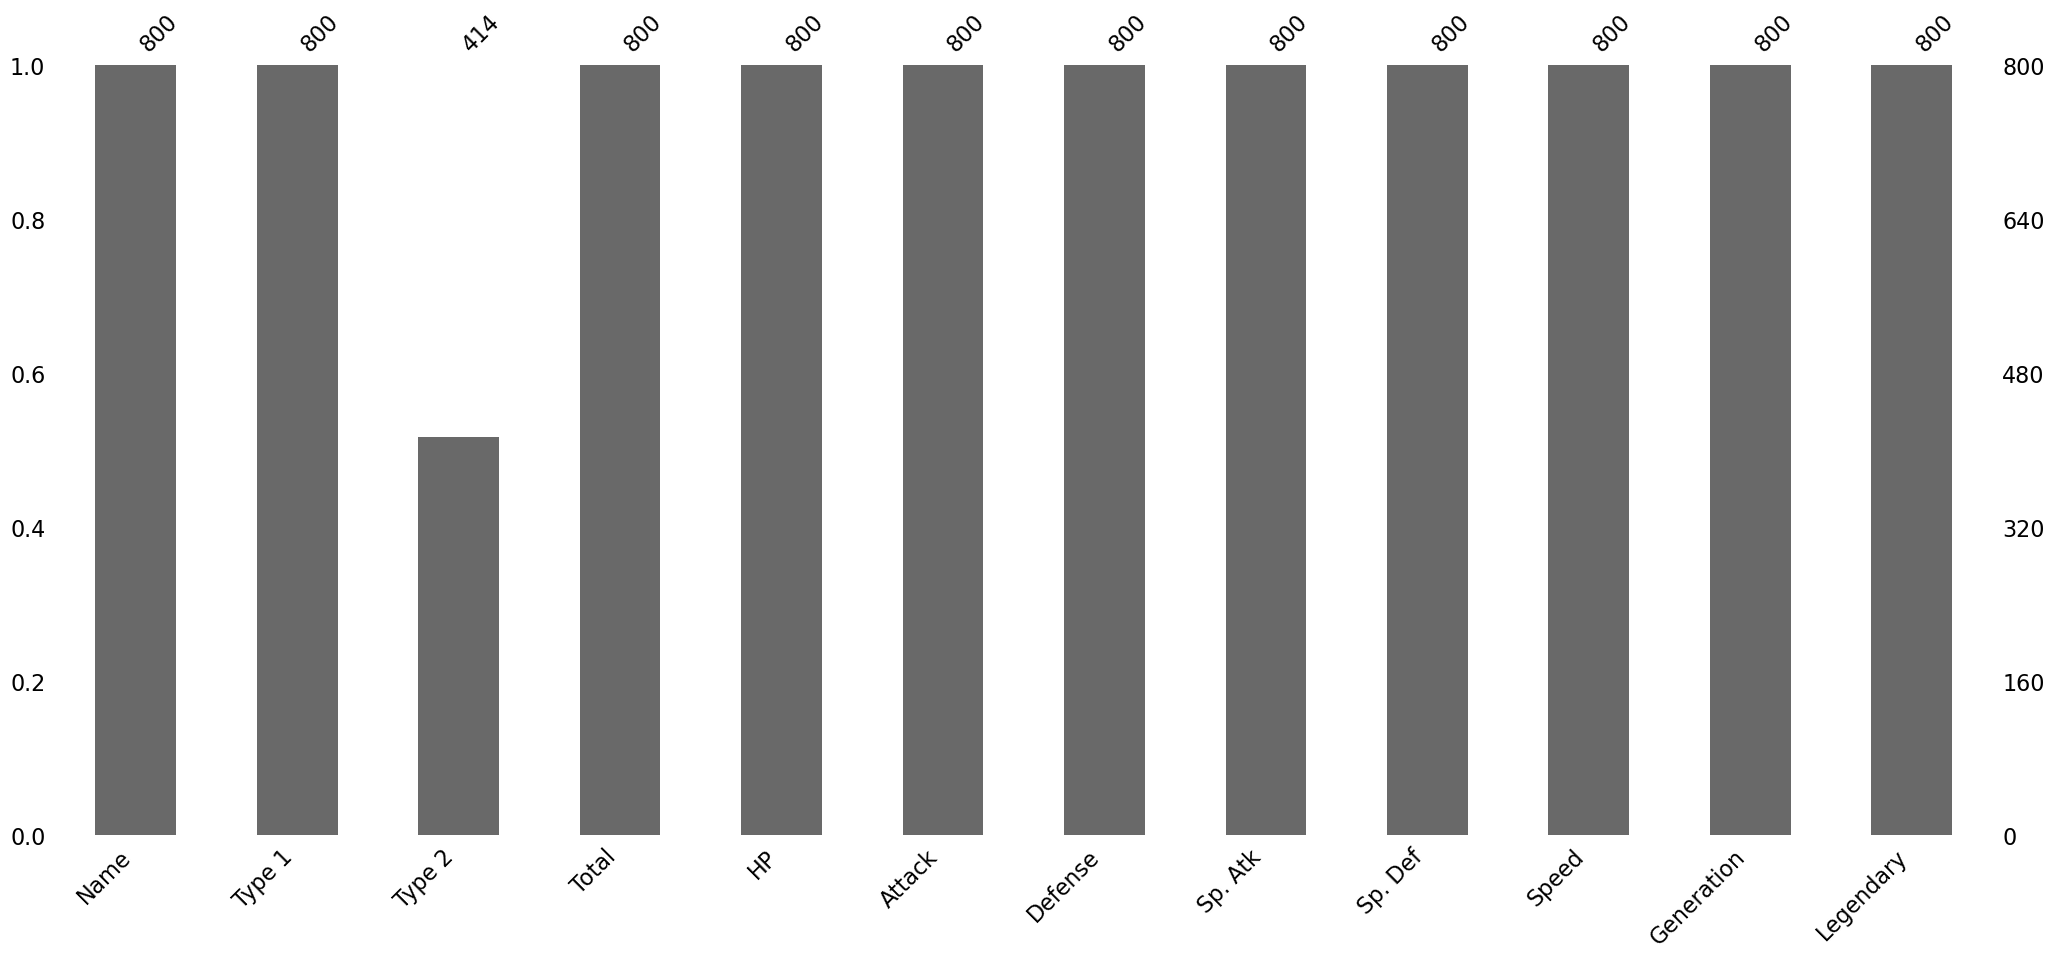

In [4]:
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline
msno.bar(df)

In [5]:
df = df.fillna('Missing')
df.head()

Name Type 1   Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
0   80.0  Grass   Poison    318  45      49       49       65       65     45   
1  329.0  Grass   Poison    405  60      62       63       80       80     60   
2  745.0  Grass   Poison    525  80      82       83      100      100     80   
3  746.0  Grass   Poison    625  80     100      123      122      120     80   
4  102.0   Fire  Missing    309  39      52       43       60       50     65   

   Generation  Legendary  
0           1      False  
1           1      False  
2           1      False  
3           1      False  
4           1      False

For the missing data, I thought is better to replace 'NaN', by 'Missing' so in the data set there will be an empty string.

In [6]:
from sklearn.preprocessing import OneHotEncoder
columns_to_encode = ['Type 1', 'Type 2']
data_to_encode = df[columns_to_encode]

encoder = OneHotEncoder(sparse=False, drop='first')

encoded_data = encoder.fit_transform(data_to_encode)

df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

df = pd.concat([df, df_encoded], axis=1)

df = df.drop(columns=columns_to_encode)
df.head()

Name  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  \
0   80.0    318  45      49       49       65       65     45           1   
1  329.0    405  60      62       63       80       80     60           1   
2  745.0    525  80      82       83      100      100     80           1   
3  746.0    625  80     100      123      122      120     80           1   
4  102.0    309  39      52       43       60       50     65           1   

   Legendary  ...  Type 2_Grass  Type 2_Ground  Type 2_Ice  Type 2_Missing  \
0      False  ...           0.0            0.0         0.0             0.0   
1      False  ...           0.0            0.0         0.0             0.0   
2      False  ...           0.0            0.0         0.0             0.0   
3      False  ...           0.0            0.0         0.0             0.0   
4      False  ...           0.0            0.0         0.0             1.0   

   Type 2_Normal  Type 2_Poison  Type 2_Psychic  Type 2_Rock  Type 2_Steel  \
0            0.0            1.0             0.0          0.0           0.0   
1            0.0            1.0             0.0          0.0           0.0   
2            0.0            1.0             0.0          0.0           0.0   
3            0.0            1.0             0.0          0.0           0.0   
4            0.0            0.0             0.0          0.0           0.0   

   Type 2_Water  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 45 columns]

Now the dimensionality of data is increased, thus we can expect better results when training the model.

In [7]:
correlation_matrix = df.corr()
price_correlation = correlation_matrix['Legendary'].abs().sort_values(ascending=False)
price_correlation

Legendary          1.000000
Total              0.501758
Sp. Atk            0.448907
Sp. Def            0.363937
Attack             0.345408
Speed              0.326715
HP                 0.273620
Defense            0.246377
Type 1_Dragon      0.219463
Type 1_Psychic     0.166625
Type 1_Flying      0.108647
Type 1_Normal      0.083203
Generation         0.079794
Type 2_Dragon      0.078281
Type 2_Fire        0.076219
Type 2_Flying      0.071745
Type 1_Water       0.067244
Type 2_Ice         0.064985
Type 2_Poison      0.062652
Type 2_Missing     0.058254
Type 1_Poison      0.056635
Type 1_Fighting    0.055578
Type 2_Grass       0.053411
Type 2_Psychic     0.053344
Type 2_Fighting    0.048699
Name               0.047575
Type 1_Steel       0.045761
Type 1_Grass       0.043514
Type 2_Ground      0.041241
Type 2_Rock        0.039689
Type 1_Ground      0.032686
Type 2_Electric    0.027177
Type 2_Steel       0.022031
Type 2_Normal      0.021081
Type 2_Dark        0.018315
Type 1_Fire        0

In [8]:
top_2_columns = price_correlation[1:3].index
top_2_columns

Index(['Total', 'Sp. Atk'], dtype='object')

Now, if talking about the most correlation, we can see that the 'Total' and the 'Sp.Atk' have the most correlation with the 'Legendary' column.

## Outlier Detection

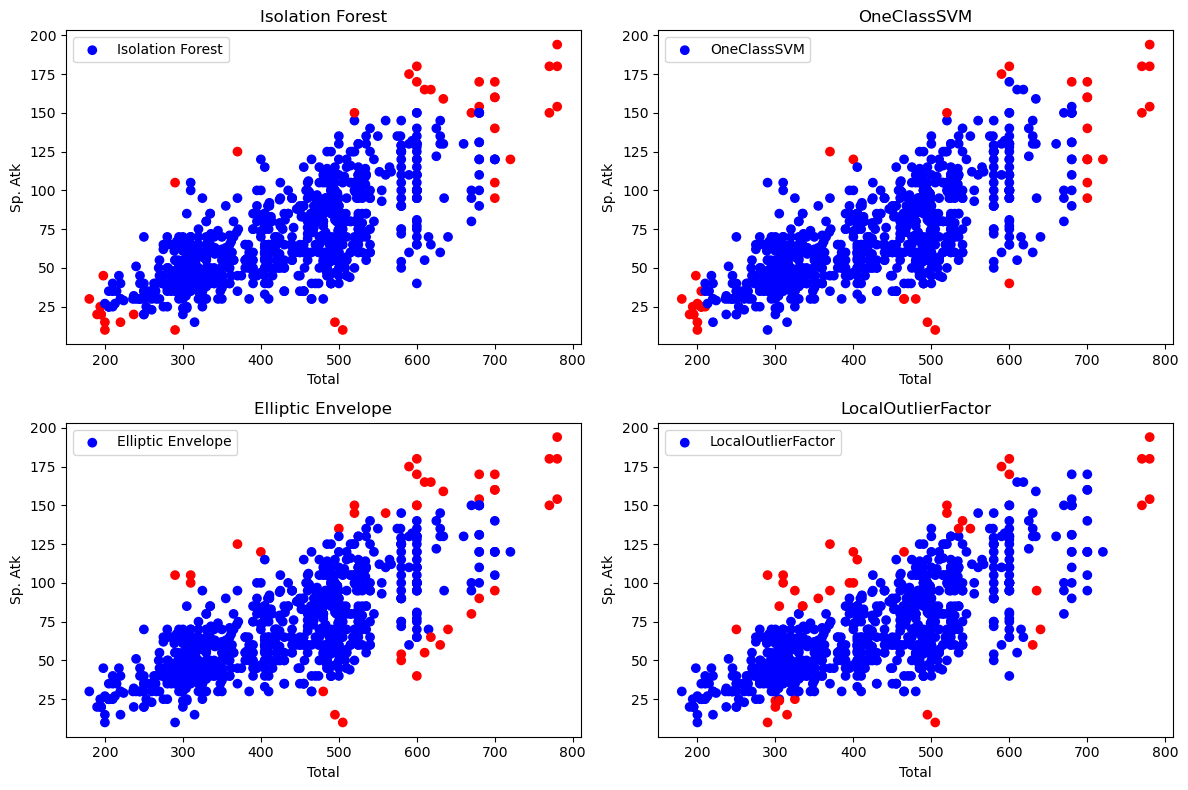

In [9]:
subset = df[top_2_columns]
outliers = {}
algorithms = {
    "Isolation Forest": IsolationForest(contamination=0.05),
    "OneClassSVM": OneClassSVM(nu=0.05),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.05),
    "LocalOutlierFactor": LocalOutlierFactor(contamination=0.05)
}

for name, algorithm in algorithms.items():
    if name == "LocalOutlierFactor":
       
        outliers[name] = algorithm.fit_predict(subset)
    else:
        
        algorithm.fit(subset)
        outliers[name] = algorithm.predict(subset)
        
plt.figure(figsize=(12, 8))

for i, (name, algorithm) in enumerate(algorithms.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(subset[top_2_columns[0]], subset[top_2_columns[1]], c=np.where(outliers[name] == -1, 'r', 'b'), label=name)
    plt.title(name)
    plt.xlabel(top_2_columns[0])
    plt.ylabel(top_2_columns[1])
    plt.legend()

plt.tight_layout()
plt.show()

Visually, the most accurate model might seem the LocalOutlierFactor, however this is only for this situation. Globally, the results might be different.

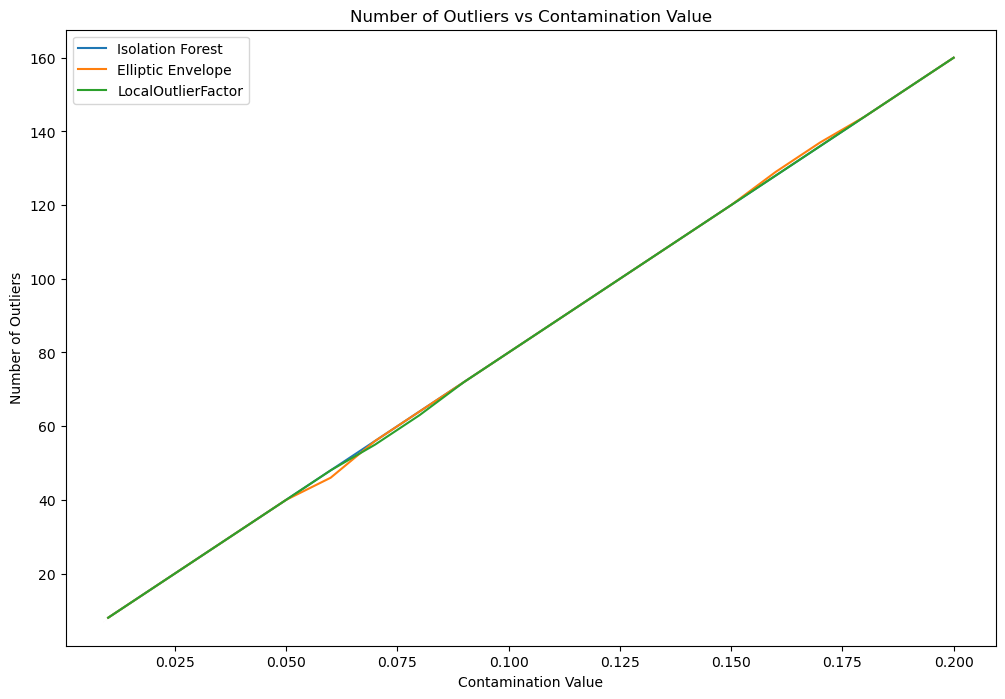

In [10]:
contamination_values = np.linspace(0.01, 0.2, 20) 

algorithms_test = {
    "Isolation Forest": IsolationForest(),
    "Elliptic Envelope": EllipticEnvelope(),
    "LocalOutlierFactor": LocalOutlierFactor()
}

outlier_counts = {name: [] for name in algorithms_test}


for name, algorithm in algorithms_test.items():
    for contamination in contamination_values:
        algorithm.set_params(contamination=contamination)

        if name == "LocalOutlierFactor":
          
            outliers = algorithm.fit_predict(subset)
            outlier_count = np.sum(outliers == -1)
        else:
            
            algorithm.fit(subset)
            outliers = algorithm.predict(subset)
            outlier_count = np.sum(outliers == -1)

        outlier_counts[name].append(outlier_count)


plt.figure(figsize=(12, 8))

for name, counts in outlier_counts.items():
    plt.plot(contamination_values, counts, label=name)

plt.title("Number of Outliers vs Contamination Value")
plt.xlabel("Contamination Value")
plt.ylabel("Number of Outliers")
plt.legend()
plt.show()

We can observe that as the nr. of outliers increase, the contamination value increases too. Means these two values are codependent. In this case, all the models manifest practically the same results.

In [11]:
X = df.drop(columns=['Legendary'])
y = df['Legendary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


outlier_algorithms = {
    "Isolation Forest": IsolationForest(contamination=0.04),
    "OneClassSVM": OneClassSVM(nu=0.04),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.04),
    "LocalOutlierFactor": LocalOutlierFactor(contamination=0.04)
}

outlier_removed_datasets = {}

for name, algorithm in outlier_algorithms.items():
    if name == "LocalOutlierFactor":
        outliers = algorithm.fit_predict(X_train)
    else:
        algorithm.fit(X_train)
        outliers = algorithm.predict(X_train)
    
    X_train_no_outliers = X_train[outliers == 1]
    y_train_no_outliers = y_train[outliers == 1]
    
    outlier_removed_datasets[name] = {'X_train': X_train_no_outliers, 'y_train': y_train_no_outliers}


prediction_algorithms = {
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor()
}

results = []

for est_name, est_algorithm in prediction_algorithms.items():
    for out_name, out_dataset in outlier_removed_datasets.items():
        est_algorithm.fit(X_train, y_train)
        y_pred = est_algorithm.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        results.append({
            'Estimator': est_name,
            'Outliers Detection Algorithm': out_name,
            'Mean Squared Error': mse
        })


results_df = pd.DataFrame(results)


results_df

Estimator Outliers Detection Algorithm  Mean Squared Error
0  Linear Regression             Isolation Forest            0.054514
1  Linear Regression                  OneClassSVM            0.054514
2  Linear Regression            Elliptic Envelope            0.054514
3  Linear Regression           LocalOutlierFactor            0.054514
4      KNN Regressor             Isolation Forest            0.028333
5      KNN Regressor                  OneClassSVM            0.028333
6      KNN Regressor            Elliptic Envelope            0.028333
7      KNN Regressor           LocalOutlierFactor            0.028333

As seen, Isolation Forest has the smallest MSE (0.054%), which might be very low, however if looking onto the target column which is 'Legendary', we can observe that there are a small nr. of records where 'Legendary' is True, so the model might be overfitted. Also, it can be seen that Linear Regression generally gives better results than KNN Regressor.